In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import datetime


from pandas import read_csv
import math
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
import tslearn
from tslearn.metrics import dtw

In [ ]:
data = pd.read_csv("Covid19-Google-Mobility-Report.csv")

data = data.rename(columns={"retail_and_recreation_percent_change_from_baseline": "retail_and_recreation", 
                     "grocery_and_pharmacy_percent_change_from_baseline": "grocery_and_pharmacy",
                    "parks_percent_change_from_baseline": "parks",
                    "transit_stations_percent_change_from_baseline": "transit_stations",
                    "workplaces_percent_change_from_baseline": "workplaces",
                    "residential_percent_change_from_baseline": "residential"})
X = data[data.country_region_code.isin(['US','MX','IT','AU','GB','RU', 'BR', 'ES', 'PE','ZA'])]
X = X[['country_region_code','date','retail_and_recreation','grocery_and_pharmacy','parks','transit_stations','workplaces','residential']]

C:\Users\hwk97\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
X['date'] = pd.to_datetime(X['date'])
X['month'] = X['date'].apply(lambda x:x.month)
X = X.set_index('country_region_code','date')
X.head()

,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,month
country_region_code,,,,,,,,
AU,2020-02-15,7.0,5.0,28.0,4.0,6.0,-1.0,2
AU,2020-02-16,8.0,19.0,34.0,16.0,2.0,-2.0,2
AU,2020-02-17,-1.0,10.0,9.0,21.0,25.0,-4.0,2
AU,2020-02-18,-2.0,-1.0,-11.0,12.0,24.0,-2.0,2
AU,2020-02-19,2.0,9.0,12.0,17.0,22.0,-3.0,2


In [ ]:
X_US = X[X.index.get_level_values(0)=='US']
X_US = X_US.groupby('date').mean()

In [ ]:
X_US_clean = X_US.dropna().loc[:,X_US.columns!='month']
X_US_clean


,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
date,,,,,,
2020-02-15,6.438312,2.379042,16.656366,4.305752,0.440956,-0.550773
2020-02-16,7.986545,2.510529,17.794574,3.750263,0.483758,-0.662211
2020-02-17,3.865924,-0.345273,27.884323,1.809293,-17.582155,4.363946
2020-02-18,-0.193126,-1.269536,5.355491,2.243528,-0.005490,0.794598
2020-02-19,2.079837,0.579079,7.988456,2.474335,0.884461,0.177349
...,...,...,...,...,...,...
2020-09-07,-0.048428,2.620592,104.408416,-12.889772,-67.014669,15.277952
2020-09-08,1.503053,6.475066,66.047904,-11.180328,-27.914183,6.237864
2020-09-09,2.013489,4.974274,70.129630,-10.569113,-26.283303,5.751710


In [ ]:
X_US_clean

,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
date,,,,,,
2020-02-15,6.438312,2.379042,16.656366,4.305752,0.440956,-0.550773
2020-02-16,7.986545,2.510529,17.794574,3.750263,0.483758,-0.662211
2020-02-17,3.865924,-0.345273,27.884323,1.809293,-17.582155,4.363946
2020-02-18,-0.193126,-1.269536,5.355491,2.243528,-0.005490,0.794598
2020-02-19,2.079837,0.579079,7.988456,2.474335,0.884461,0.177349
...,...,...,...,...,...,...
2020-09-07,-0.048428,2.620592,104.408416,-12.889772,-67.014669,15.277952
2020-09-08,1.503053,6.475066,66.047904,-11.180328,-27.914183,6.237864
2020-09-09,2.013489,4.974274,70.129630,-10.569113,-26.283303,5.751710


In [ ]:
pca = PCA(n_components=3)
pca.fit(X_US_clean)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
pca.components_

[0.73669741 0.21255384 0.03266328]
[505.51974802 271.53638388 106.44455817]


array([[-0.33543398, -0.15684068, -0.87711706, -0.2632433 , -0.11775018,
         0.10192433],
       [-0.44018413, -0.16306784,  0.42813002, -0.41058178, -0.62012621,
         0.2078884 ],
       [ 0.58152078,  0.33949353, -0.20950391,  0.13252948, -0.66489339,
         0.20745738]])

In [ ]:
X_US_clean.sort_index()

,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
date,,,,,,
2020-02-15,6.438312,2.379042,16.656366,4.305752,0.440956,-0.550773
2020-02-16,7.986545,2.510529,17.794574,3.750263,0.483758,-0.662211
2020-02-17,3.865924,-0.345273,27.884323,1.809293,-17.582155,4.363946
2020-02-18,-0.193126,-1.269536,5.355491,2.243528,-0.005490,0.794598
2020-02-19,2.079837,0.579079,7.988456,2.474335,0.884461,0.177349
...,...,...,...,...,...,...
2020-09-07,-0.048428,2.620592,104.408416,-12.889772,-67.014669,15.277952
2020-09-08,1.503053,6.475066,66.047904,-11.180328,-27.914183,6.237864
2020-09-09,2.013489,4.974274,70.129630,-10.569113,-26.283303,5.751710


In [ ]:
case_data = pd.read_csv("Covid19-cases.csv")
case_data_US = case_data[case_data.country_region=='US'][['country_region','date','confirmed','deaths','recovered']]
case_data_US['date'] = pd.to_datetime(case_data_US['date'])
case_data_US_agg = case_data_US.groupby('date').sum()
case_data_US_agg['new_confirmed'] = case_data_US_agg['confirmed'].diff().fillna(0)
case_data_US_agg.sort_index().head()

C:\Users\hwk97\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,confirmed,deaths,recovered,new_confirmed
date,,,,
2020-01-22,1.0,0.0,0.0,0.0
2020-01-23,1.0,0.0,0.0,0.0
2020-01-24,2.0,0.0,0.0,1.0
2020-01-25,2.0,0.0,0.0,0.0
2020-01-26,5.0,0.0,0.0,3.0


In [ ]:
merge_data_US = X_US_clean.join(case_data_US_agg[['new_confirmed']])
merge_data_US['shift_new_confirmed_cases'] = merge_data_US['new_confirmed'].shift(-7)

from sklearn import preprocessing

merge_data_US_clean = merge_data_US.dropna()[['retail_and_recreation','grocery_and_pharmacy','parks','transit_stations','workplaces','residential','shift_new_confirmed_cases']]

min_max_scaler = preprocessing.MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(merge_data_US_clean.values)
merge_data_US_clean = pd.DataFrame(data_scaled,columns=['retail_and_recreation','grocery_and_pharmacy','parks','transit_stations','workplaces','residential','shift_new_confirmed_cases'])

merge_data_US_clean.head()

,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,shift_new_confirmed_cases
0,0.838649,0.638368,0.331155,0.835306,0.955478,0.059824,0.000000
1,0.857615,0.640351,0.340796,0.826086,0.956086,0.055143,0.000000
2,0.807137,0.597286,0.426258,0.793872,0.699504,0.266261,0.000230
3,0.757413,0.583348,0.235435,0.801079,0.949138,0.116335,0.000000
4,0.785257,0.611225,0.257737,0.804910,0.961777,0.090408,0.000077


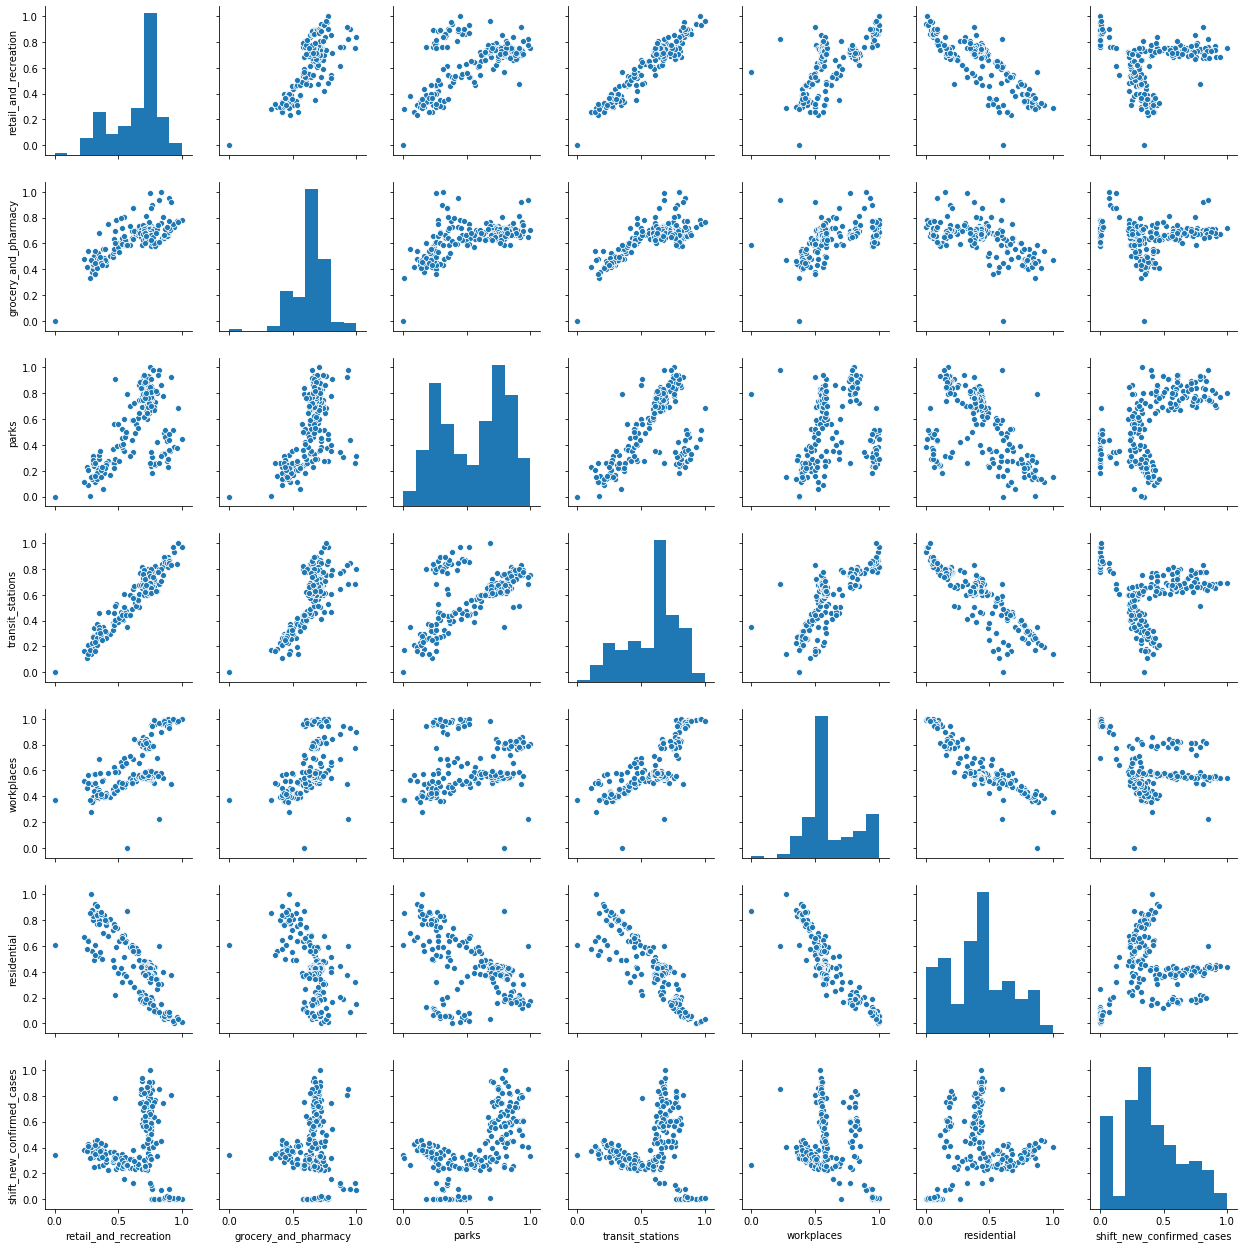

In [ ]:
import seaborn as sns
sns.pairplot(data=merge_data_US_clean)

In [ ]:
X = merge_data_US_clean[['retail_and_recreation','grocery_and_pharmacy','parks','transit_stations','workplaces','residential']]
y = merge_data_US_clean[['shift_new_confirmed_cases']]

#### 1. Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))

0.674107779574291


In [ ]:
coef = [-1.0923429440386774,
 -0.2355353134980063,
 0.5762593241876154,
 1.1442509483013992,
 -1.139208066383788,
 -0.25326717114378583]
list(reg.coef_[0])


<BarContainer object of 6 artists>

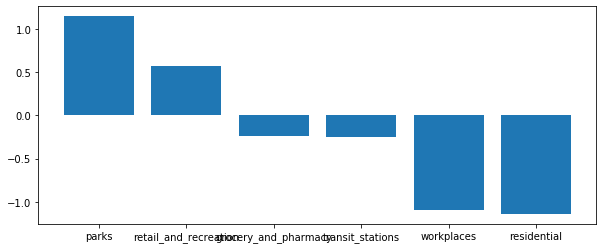

In [ ]:
coeff = sorted(list(reg.coef_[0]),reverse=True)
name = ['parks','retail_and_recreation','grocery_and_pharmacy','transit_stations','workplaces','residential']
plt.figure(figsize=(10,4))
plt.bar(name, coeff)


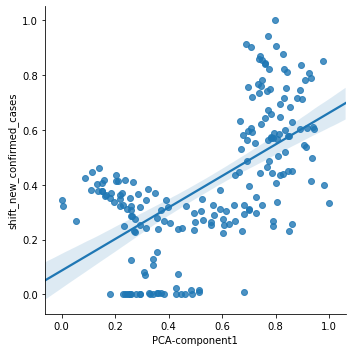

In [ ]:
merge_data_US_clean = merge_data_US_clean.rename(columns={"parks":"PCA-component1"})

sns.lmplot(data=merge_data_US_clean, x='PCA-component1', y='shift_new_confirmed_cases')

#### 2. XgBoost

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 6, alpha = 10, n_estimators = 10)

In [ ]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

[08:53:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.239369


In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=15,metrics="rmse", as_pandas=True, seed=123)

[08:53:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.264686,0.005757,0.264048,0.026629
1,0.262234,0.006432,0.261549,0.026472
2,0.259396,0.007175,0.259190,0.024508
3,0.255869,0.006716,0.256278,0.024939
4,0.252795,0.005987,0.253225,0.025517


In [ ]:
import seaborn

[08:53:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


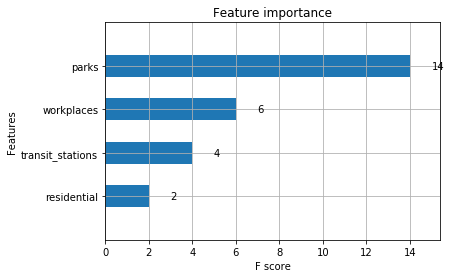

In [ ]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=25)
xgb.plot_importance(xg_reg,height=0.5)

plt.rcParams['figure.figsize'] = [7, 5]
plt.show()


In [ ]:
from string import ascii_letters
import seaborn as sns

#sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)


# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(5, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})